In [0]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets import fetch_lfw_people, fetch_olivetti_faces
from scipy import linalg
from random import uniform
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import cv2
import bz2
import pickle
import _pickle as cPickle
from random import uniform
from sklearn.model_selection import train_test_split


In [2]:
# Mount directories
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# import my utility functions
import sys
sys.path.append('/content/gdrive/My Drive/CSCI1430_Final_Project/')
from utils import *

In [0]:
# These two function couldn't get imported through the utils file on colab
"""
Load any compressed pickle file
"""
def decompress_pickle(file):
  data = bz2.BZ2File(file, 'rb')
  data = cPickle.load(data)
  return data

"""
Generates novel face based on the following formula:
New Face = (mean face) + sum(random scalar * eigenfaces)
"""
def generate_new_face(mean_face, eigenfaces, height, width, minScale=-3000, maxScale=3000):
  new_face = mean_face.reshape(height,width)
  weights = []
  for i in range(len(eigenfaces)):
    random_scalar = uniform(minScale, maxScale)
    weights.append(random_scalar)
    new_face = new_face + random_scalar * eigenfaces[i].reshape(height,width)
  return new_face

Get Images

In [0]:
# # This fetches the lwf_people dataset. Let's use lfw crop instead
# lfw_people = fetch_lfw_people(min_faces_per_person=20, resize=0.4)
# lwf_people_images = lfw_people.images
# # Number of people in this dataset
# print(len(lwf_people_images))

In [5]:
# If we are using lwf_people dataset, we could use the lwf_crop dataset instead
# From: https://conradsanderson.id.au/lfwcrop/ 
# http://vis-www.cs.umass.edu/lfw/#download


path = "/content/gdrive/My Drive/CSCI1430_Final_Project/Data/lfw_crop.pbz2"
lfw_crop = decompress_pickle(path)

lfw_crop = np.asarray(lfw_crop)

num_images, height, width = lfw_crop.shape
# Number of people in dataset
print(len(lfw_crop))



13233


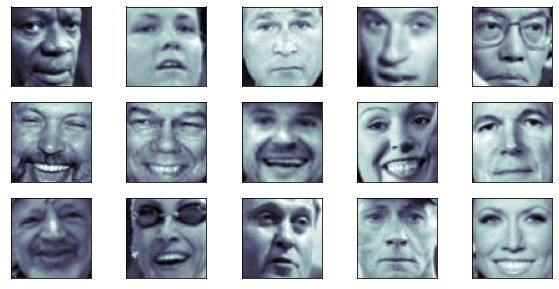

In [6]:
show_images_in_dataset(lfw_crop)

Determining Optimal Number of Components

In [0]:
# Reshape data from (number of images, height of image, width of image) to (number of images, h*w)
num_images, height, width = lfw_crop.shape
face_data = lfw_crop.reshape(num_images, height*width)

# choose number of components, doing max number of components at first, this takes a while to compute when its the max
max_components=height*width

# if you are using my own pca method, not optimized so doesn't work with max num components
# data_pca, eigenvecs, eigenvals = compute_PCA_covariance_method(face_data, max_components)
# data_pca, eigenvecs, singular_vals, mean_face = pca_using_svd(face_data, max_components)

pca_max_components = PCA(n_components=max_components, svd_solver='full',
          whiten=True).fit(lfw_crop.reshape(num_images, -1))

# Reshape flattened eigenvectors into images
# eigenfaces = eigenvecs.reshape((num_components, height, width)), this if for if you used my own PCA
eigenfaces = pca_max_components.components_.reshape((max_components, height, width))


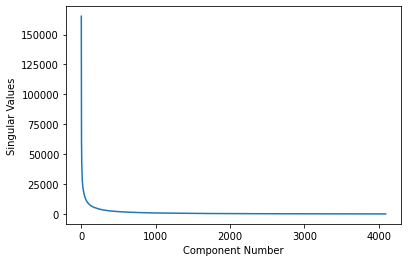

In [8]:
## Plotting components
plt.plot(pca_max_components.singular_values_)
plt.ylabel("Singular Values")
plt.xlabel("Component Number")
plt.show()

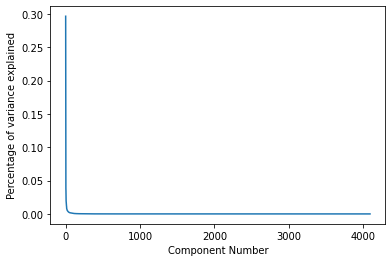

First 5 components explain 0.5665987859397885% variance in the data
First 10 components explain 0.6557213274082903% variance in the data
First 15 components explain 0.7076129931811743% variance in the data
First 30 components explain 0.7894768795736551% variance in the data
First 50 components explain 0.847252548269969% variance in the data
First 100 components explain 0.9113970862040092% variance in the data
First 250 components explain 0.9660925090558139% variance in the data


In [9]:
# Explained variance
plt.plot(pca_max_components.explained_variance_ratio_)
plt.ylabel("Percentage of variance explained")
plt.xlabel("Component Number")
plt.show()

print("First 5 components explain {}% variance in the data".format(np.sum(pca_max_components.explained_variance_ratio_[0:5])))
print("First 10 components explain {}% variance in the data".format(np.sum(pca_max_components.explained_variance_ratio_[0:10])))
print("First 15 components explain {}% variance in the data".format(np.sum(pca_max_components.explained_variance_ratio_[0:15])))
print("First 30 components explain {}% variance in the data".format(np.sum(pca_max_components.explained_variance_ratio_[0:30])))
print("First 50 components explain {}% variance in the data".format(np.sum(pca_max_components.explained_variance_ratio_[0:50])))
print("First 100 components explain {}% variance in the data".format(np.sum(pca_max_components.explained_variance_ratio_[0:100])))
print("First 250 components explain {}% variance in the data".format(np.sum(pca_max_components.explained_variance_ratio_[0:250])))



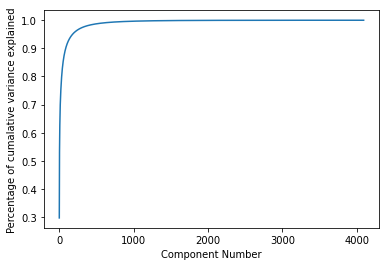

First 5 components explain 0.5882175698363753% variance in the data
First 50 components explain 0.8493276285298338% variance in the data
First 100 components explain 0.9121692351787823% variance in the data
First 250 components explain 0.9662605206060751% variance in the data


In [10]:
# Different explained variance graph
cumalative_variance = np.cumsum(pca_max_components.explained_variance_ratio_)
plt.plot(cumalative_variance)
plt.ylabel("Percentage of cumalative variance explained")
plt.xlabel("Component Number")
plt.show()

print("First 5 components explain {}% variance in the data".format(cumalative_variance[5]))
print("First 50 components explain {}% variance in the data".format(cumalative_variance[50]))
print("First 100 components explain {}% variance in the data".format(cumalative_variance[100]))
print("First 250 components explain {}% variance in the data".format(cumalative_variance[250]))

# An eigenvalue greater than 1 indicates that principal component accounts for more variance than accounted by one of the original variables in standardized data. This could be used to threshold to determine the number of eigenvectors.


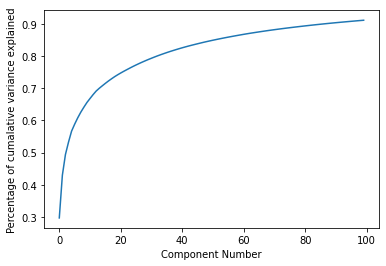

First 5 components explain 0.5882175698363753% variance in the data
First 10 components explain 0.6680703764285936% variance in the data
First 15 components explain 0.715246462508949% variance in the data
First 20 components explain 0.7474483402336746% variance in the data
First 50 components explain 0.8493276285298338% variance in the data
First 100 components explain 0.9121692351787823% variance in the data
First 250 components explain 0.9662605206060751% variance in the data


In [11]:
# Only show first 100 to make it easier to see
cumalative_variance = np.cumsum(pca_max_components.explained_variance_ratio_)
plt.plot(cumalative_variance[:100])
plt.ylabel("Percentage of cumalative variance explained")
plt.xlabel("Component Number")
plt.show()

print("First 5 components explain {}% variance in the data".format(cumalative_variance[5]))

print("First 10 components explain {}% variance in the data".format(cumalative_variance[10]))
print("First 15 components explain {}% variance in the data".format(cumalative_variance[15]))
print("First 20 components explain {}% variance in the data".format(cumalative_variance[20]))

print("First 50 components explain {}% variance in the data".format(cumalative_variance[50]))
print("First 100 components explain {}% variance in the data".format(cumalative_variance[100]))
print("First 250 components explain {}% variance in the data".format(cumalative_variance[250]))

# An eigenvalue greater than 1 indicates that principal component accounts for more variance than accounted by one of the original variables in standardized data. This could be used to threshold to determine the number of eigenvectors.


Eigenface stuff now that I know how many components to use



In [0]:
# choose number of components, choosing 250 based off previous experiment
num_components=250

# Now we can use my own PCA, without it crashing colab because not using max components
data_pca, eigenvecs, singular_vals, mean_face = pca_using_svd(face_data, num_components)


# data_pca, eigenvecs, eigenvals = compute_PCA_covariance_method(face_data, num_components)
# data_pca, eigenvecs, singular_vals, mean_face = pca_using_svd(face_data, num_components)

# pca_reduced_num_components = PCA(n_components=num_components, svd_solver='randomized',
#           whiten=True).fit(lfw_crop.reshape(num_images, -1))
# mean_face = pca_reduced_num_components.mean_
# eigenvecs = pca_reduced_num_components.components_

# Reshape flattened eigenvectors into images
eigenfaces = eigenvecs.reshape((num_components, height, width))

These are the top 15 eigenfaces ordered by how much variation they have (correspond to largest eigenvalues)


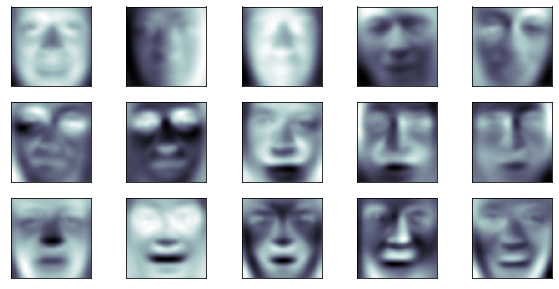

In [13]:
# Shows 15 of the eigenfaces in the dataset
show_images_in_dataset(eigenfaces)
print("These are the top 15 eigenfaces ordered by how much variation they have \
(correspond to largest eigenvalues)")

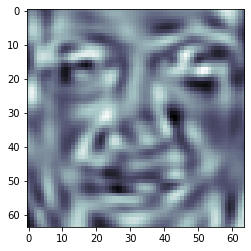

In [14]:
# Face generation
new_face = generate_new_face(mean_face, eigenfaces, height, width, -2000, 2000)
imgplot = plt.imshow(new_face, cmap=plt.cm.bone)




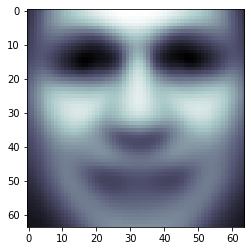

In [15]:
# Here's the average face of the face dataset
imgplot = plt.imshow(mean_face.reshape(height,width), cmap=plt.cm.bone)


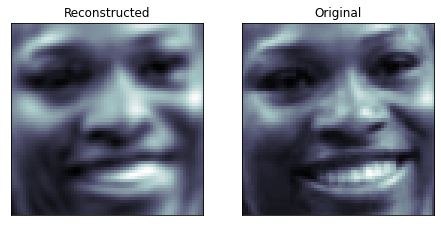

In [16]:
# Show off face reconstruction
face_to_reconstruct = lfw_crop[30]
# face_to_reconstruct = np.random.rand(64,64)
reconstructed_face = reconstruct_face(face_to_reconstruct, mean_face, eigenvecs)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(3, 5, 2, xticks=[], yticks=[])
ax.imshow(face_to_reconstruct, cmap=plt.cm.bone)
ax.title.set_text('Original')
ax = fig.add_subplot(3, 5, 1, xticks=[], yticks=[])
ax.imshow(reconstructed_face, cmap=plt.cm.bone)
ax.title.set_text('Reconstructed')




(64, 64)
Reconstruction of face, that is not in training dataset


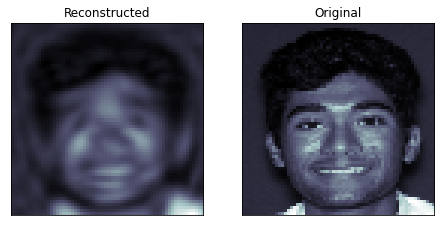

In [17]:
path_to_myself = "/content/gdrive/My Drive/CSCI1430_Final_Project/Data/neilBW.png"

me = cv2.imread(path_to_myself, 0)
me = cv2.resize(me, (64, 64))
me = np.asarray(me)
print(me.shape)

reconstructed_face = reconstruct_face(me, mean_face, eigenvecs)
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(3, 5, 1, xticks=[], yticks=[])
ax.imshow(reconstructed_face, cmap=plt.cm.bone)
ax.title.set_text('Reconstructed')
ax = fig.add_subplot(3, 5, 2, xticks=[], yticks=[])
ax.imshow(me, cmap=plt.cm.bone)
ax.title.set_text('Original')

print("Reconstruction of face, that is not in training dataset")



FACIAL RECOGNITION PART

I used this paper as inspiration:
http://ijarcet.org/wp-content/uploads/IJARCET-VOL-1-ISSUE-9-135-139.pdf

In [18]:
olivetti = fetch_olivetti_faces()
id_labels = olivetti.target
olivetti_faces = olivetti.images
uniques_faces_idx = np.unique(olivetti.target)*10



downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


These are 15 of the 40 people in the dataset


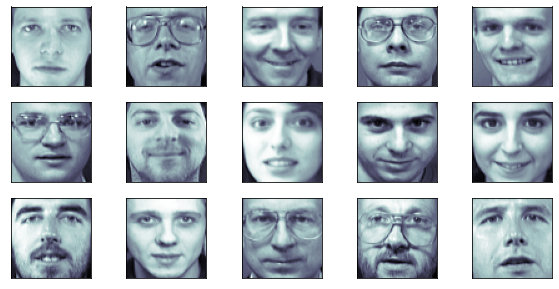

In [19]:
show_images_in_dataset(olivetti.images[uniques_faces_idx])
print("These are 15 of the 40 people in the dataset")

In [0]:
# get weights of olivetti faces in lfw_crop pca component space
olivetti_projections = np.dot((olivetti_faces.reshape(400, -1) - mean_face.reshape(-1)), eigenvecs.T)

In [0]:
# Accuracy vs number of components

In [0]:
# project olivetti faces down to component space
# component space is pca fitted on lfw_crop dataset
olivetti_projections = np.dot((olivetti_faces.reshape(400, -1) - mean_face.reshape(-1)), eigenvecs.T)


# number of components to take
component_list = [1,2,3,4,5, 10, 20, 50, 100]
component_list = [1,2,4,8,16,32,64, 128, 250]


# number of images per person to train on 
percent_train_list = [1,2,3,4,5,6,7,8,9]

accuracy_mat = np.zeros((len(component_list), len(percent_train_list)+1))


for c_idx in range(len(component_list)):
  c = component_list[c_idx]
  olive = olivetti_projections[:, :c]
  # print(olive.shape)

  for train_amount in percent_train_list:
    X_train, X_test, y_train, y_test = train_test_split(olive \
    , id_labels, test_size=(1-train_amount/10), random_state=42, stratify=id_labels)

    # Just use closest based on euclidean distance
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)
    acc = knn.score(X_test, y_test)
    # print("Accuracy at predicting identification of {} faces in test set is: {}".format(len(testY), acc))
    accuracy_mat[c_idx, train_amount] = acc

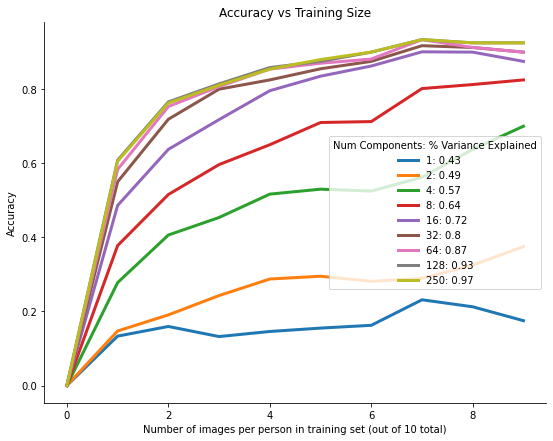

In [24]:
plt.figure(figsize=(9,7))

labels = [str(i) + ": " + str(np.round(cumalative_variance[i], 2)) for i in component_list]
plt.plot(accuracy_mat.T, lw=3)
plt.legend(labels, title="Num Components: % Variance Explained")
# plt.xlim(0, 10)
# plt.plot(accuracy, alpha=0.5, lw=7)
plt.xlabel('Number of images per person in training set (out of 10 total)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Training Size')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

Different test train splits, based on random state, give us different accuracies
Top accuracy with random state 38 is :  0.925
Top accuracy with random state 49 is :  0.85625


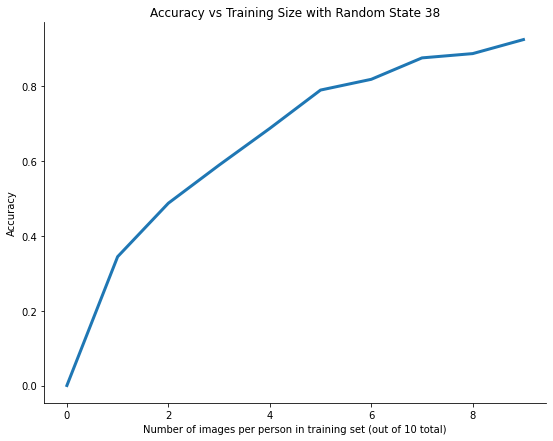

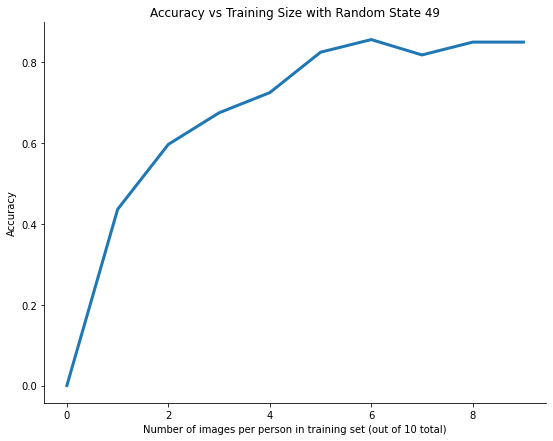

In [47]:
# Note different test train splits give us varying accuracies
print("Different test train splits, based on random state, give us different accuracies") 

percent_train_list = [1,2,3,4,5,6,7,8,9]

olive = olivetti_projections[:, :10]

acc = np.zeros((len(percent_train_list)+1))
for train_amount in percent_train_list:
    X_train, X_test, y_train, y_test = train_test_split(olive \
    , id_labels, test_size=(1-train_amount/10), random_state=38, stratify=id_labels)
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)
    acc[train_amount] = knn.score(X_test, y_test)
plt.figure(figsize=(9,7))

plt.plot(acc.T, lw=3)
plt.xlabel('Number of images per person in training set (out of 10 total)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Training Size with Random State 38')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
print("Top accuracy with random state 38 is : ", np.max(acc))

acc = np.zeros((len(percent_train_list)+1))
for train_amount in percent_train_list:
    X_train, X_test, y_train, y_test = train_test_split(olive \
    , id_labels, test_size=(1-train_amount/10), random_state=49, stratify=id_labels)
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)
    acc[train_amount] = knn.score(X_test, y_test)
plt.figure(figsize=(9,7))

plt.plot(acc.T, lw=3)
plt.xlabel('Number of images per person in training set (out of 10 total)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Training Size with Random State 49')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
print("Top accuracy with random state 49 is : ", np.max(acc))


In [0]:
# Since, we see pretty huge variations of accuracy based on different random splits of the data
# We'll take the average of the accuracy across 10 different random splits of the data

# project olivetti faces down to component space
# component space is pca fitted on lfw_crop dataset
olivetti_projections = np.dot((olivetti_faces.reshape(400, -1) - mean_face.reshape(-1)), eigenvecs.T)


# number of components to take
component_list = [1,2,4,8,16,32,64, 128, 250]


# number of images per person to train on 
percent_train_list = [1,2,3,4,5,6,7,8,9]

accuracy_mat = np.zeros((len(component_list), len(percent_train_list)+1))

for r in range(10):
  for c_idx in range(len(component_list)):
    c = component_list[c_idx]
    olive = olivetti_projections[:, :c]
    # print(olive.shape)

    for train_amount in percent_train_list:
      X_train, X_test, y_train, y_test = train_test_split(olive \
      , id_labels, test_size=(1-train_amount/10), random_state=r, stratify=id_labels)

      # Just use closest based on euclidean distance
      knn = KNeighborsClassifier(n_neighbors=1)
      knn.fit(X_train, y_train)
      acc = knn.score(X_test, y_test)
      # print("Accuracy at predicting identification of {} faces in test set is: {}".format(len(testY), acc))
      accuracy_mat[c_idx, train_amount] += acc
accuracy_mat = accuracy_mat/10

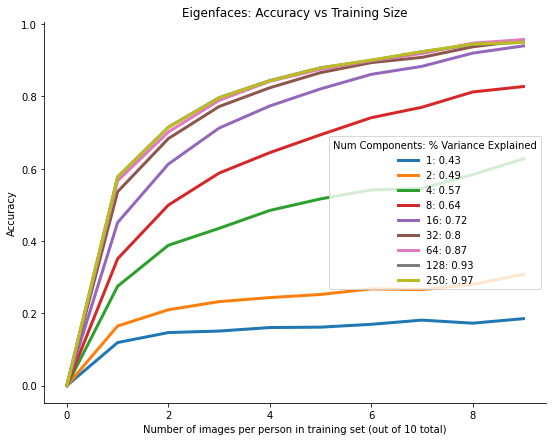

In [52]:
plt.figure(figsize=(9,7))

labels = [str(i) + ": " + str(np.round(cumalative_variance[i], 2)) for i in component_list]
plt.plot(accuracy_mat.T, lw=3)
plt.legend(labels, title="Num Components: % Variance Explained")
# plt.xlim(0, 10)
# plt.plot(accuracy, alpha=0.5, lw=7)
plt.xlabel('Number of images per person in training set (out of 10 total)')
plt.ylabel('Accuracy')
plt.title('Eigenfaces: Accuracy vs Training Size')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [50]:
print("Highest accuracy achieved: ", np.max(accuracy_mat))

Highest accuracy achieved:  0.9574999999999999


In [51]:
print("Accuracies when taking 250 components at increasing number of training images:")
print(accuracy_mat[-1, :])

Accuracies when taking 250 components at increasing number of training images:
[0.         0.5775     0.714375   0.79607143 0.84333333 0.879
 0.900625   0.92396694 0.945      0.95      ]
